In [1]:
import pandas as pd
import numpy as np

import mne
from mne.time_frequency import psd_welch

import helper as helper #custom

# visualization stuff
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# 1. Import Data

In [2]:
df = pd.read_csv('data/ssvep-5trials-3s.csv')

In [3]:
df.shape #check the size of 0

(19944, 10)

In [4]:
print(df[df.Marker==3].shape) #15hz
print(df[df.Marker==2].shape) #10hz
print(df[df.Marker==1].shape) #6hz

(5, 10)
(5, 10)
(5, 10)


df.rename(columns={'Unnamed: 1':'Fp1',
                          'Unnamed: 2':'Fp2',
                          'Unnamed: 3':'F3',
                          'Unnamed: 4':'F4'}, 
                 inplace=True)

In [5]:
df.rename(columns={'Unnamed: 1':'O1',
                          'Unnamed: 2':'Oz',
                          'Unnamed: 3':'O2'}, 
                 inplace=True)

In [6]:
df.head()

,timestamps,O1,Oz,O2,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Marker
0,1556.542,48705.523,15869.537,44876.559,-187500.016,-187500.016,-187500.016,-187500.016,-187500.016,0
1,1556.543,48959.215,16080.873,45128.059,-187500.016,-187500.016,-187500.016,-187500.016,-187500.016,0
2,1556.543,48725.508,15920.410,44873.699,-187500.016,-187500.016,-187500.016,-187500.016,-187500.016,0
3,1556.543,48252.699,15543.426,44381.938,-187500.016,-187500.016,-187500.016,-187500.016,-187500.016,0
4,1556.543,48317.879,15567.521,44479.816,-187500.016,-187500.016,-187500.016,-187500.016,-187500.016,0


In [7]:
df = df.drop(["timestamps",  "Unnamed: 4", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8"], axis=1)

df = df.drop(["timestamps"], axis=1)

In [8]:
df.head()

,O1,Oz,O2,Marker
0,48705.523,15869.537,44876.559,0
1,48959.215,16080.873,45128.059,0
2,48725.508,15920.410,44873.699,0
3,48252.699,15543.426,44381.938,0
4,48317.879,15567.521,44479.816,0


# 2. Transform Data into Raw MNE object

Creating RawArray with float64 data, n_channels=4, n_times=19944
    Range : 0 ... 19943 =      0.000 ...    79.772 secs
Ready.
Effective window size : 8.192 (s)


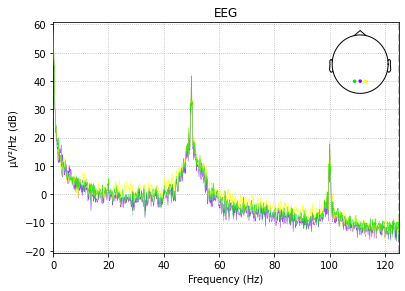

In [9]:
raw = helper.df_to_raw(df)

# 3. Preprocessing

## Notch Filter

Some artifacts are restricted to certain frequencies and can therefore be fixed by filtering. An artifact that typically affects only some frequencies is due to the power line.

Power-line noise is a noise created by the electrical network. It is composed of sharp peaks at 50Hz (or 60Hz depending on your geographical location). Some peaks may also be present at the harmonic frequencies, i.e. the integer multiples of the power-line frequency, e.g. 100Hz, 150Hz, … (or 120Hz, 180Hz, …).

Remove the 50Hz power line noise in Thailand.  We will also be remove its harmonics, i.e., 100Hz, 150Hz, etc.  Since our signal is 125Hz (250Hz / 2 according to Nyquist Theorem), we shall run the harmonics until 125 Hz.

In [10]:
raw.notch_filter(np.arange(50, 125, 50), filter_length='auto', phase='zero') #250/2 based on Nyquist Theorem

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)



<RawArray | 4 x 19944 (79.8 s), ~640 kB, data loaded>

Effective window size : 8.192 (s)


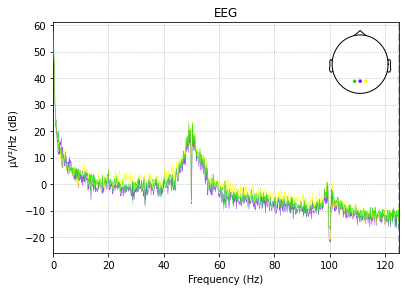

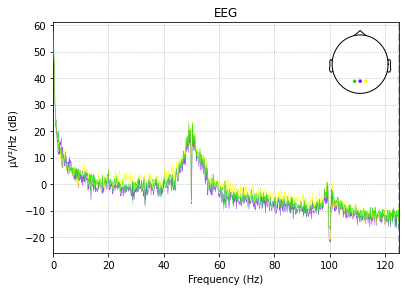

In [11]:
#observe that the 50Hz noise is now gone, yay!
raw.plot_psd()

## Band pass filter

If we are working on ERP (e.g., P300, SSVEP, N170), then we need to filter out all frequences between 1 and 30hz in order to increase our ability to detect them.

Since we are interested in spectral analysis, our interested band is around 4 and 50Hz

In [12]:
#Filter code looks like this
raw.filter(4,20, method='iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 20.00 Hz: -6.02, -6.02 dB



<RawArray | 4 x 19944 (79.8 s), ~640 kB, data loaded>

## Independent component analysis

We can skip this as SSVEP is not sensitive to eye-artifacts

# 3. Epoching

In [13]:
#this one requires expertise to specify the right tmin, tmax
event_id = {'6Hz': 1, '10Hz' : 2, '15Hz' : 3}
epochs = helper.getEpochs(raw, event_id, tmin=0, tmax=3)

15 events found
Event IDs: [1 2 3]
sample drop %:  0.0


## Stimuli-Specific PSD

Effective window size : 4.112 (s)
Effective window size : 4.112 (s)
Effective window size : 4.112 (s)


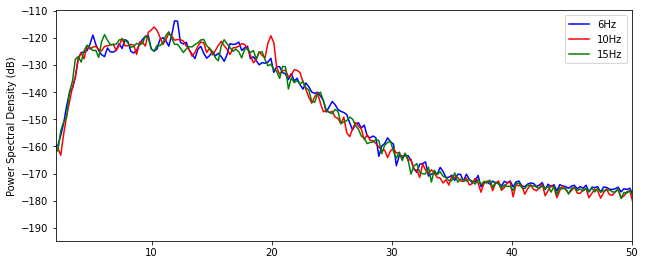

In [14]:
fig = plt.figure(figsize=(10, 4))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

psd1, freq1 = psd_welch(epochs['6Hz'], n_fft=1028, n_per_seg=256 * 3)
psd2, freq2 = psd_welch(epochs['10Hz'], n_fft=1028, n_per_seg=256 * 3)
psd3, freq3 = psd_welch(epochs['15Hz'], n_fft=1028, n_per_seg=256 * 3)

logpsd1 = 10 * np.log10(psd1)
logpsd2 = 10 * np.log10(psd2)
logpsd3 = 10 * np.log10(psd3)


log_psd1_mean = logpsd1.mean(0)
log_psd1_std = logpsd1.mean(0)

log_psd2_mean = logpsd2.mean(0)
log_psd2_std = logpsd2.mean(0)

log_psd3_mean = logpsd3.mean(0)
log_psd3_std = logpsd3.mean(0)

axes.plot(freq1, log_psd1_mean[[0, 2], :].mean(0), color='b', label='6Hz')
axes.plot(freq2, log_psd2_mean[[0, 2], :].mean(0), color='r', label='10Hz')
axes.plot(freq2, log_psd3_mean[[0, 2], :].mean(0), color='g', label='15Hz')

axes.set_title('')
axes.set_ylabel('Power Spectral Density (dB)')
axes.set_xlim((2, 50))
axes.legend()

# Decoding

In [15]:
epochs.pick_types(eeg=True)
X = epochs.get_data() #n_epochs * n_channel * n_time_samples  
 #CSP will take in data in this form and create features of 2d
y = epochs.events[:, -1]
print(X.shape)
print(y.shape)

(15, 3, 751)
(15,)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 20.00 Hz: -6.02, -6.02 dB

15 events found
Event IDs: [1 2 3]
sample drop %:  0.0
+

/home/chaklam/bci_project/bci_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/chaklam/bci_project/bci_env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


+++++++        AUC
0  1.000000
1  1.000000
2  1.000000
3  0.333333
4  1.000000


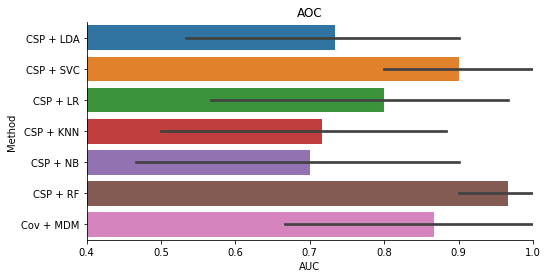

In [16]:
import filterbankcspDecoding as fcsp #custom

fcsp.decode(raw, event_id, tmin=0, tmax=3)